# A/B Testing Fundamentals: Randomized Controlled Trials

A/B testing is the practical application of **Randomized Controlled Trials (RCTs)** to decision-making. It's more fundamental than causal inference methods because randomization eliminates the need for complex adjustment strategies.

## Learning Objectives

1. Understand why randomization is the gold standard for causal inference
2. Learn statistical testing with different probability distributions
3. Compute sample sizes and power analysis
4. Recognize common pitfalls in A/B testing
5. Apply A/B testing to biological and business scenarios

## Why RCTs Work

Randomization achieves four critical goals:

1. **Breaks confounder-treatment link**: Treatment assignment is independent of all confounders (measured and unmeasured)
2. **Creates comparable groups**: Treated and control groups are statistically identical in expectation
3. **Unbiased estimation**: The naive difference-in-means estimator is unbiased
4. **No adjustment needed**: We don't need to measure or adjust for confounders

This is why A/B testing is so powerful—and why it's the foundation of evidence-based medicine, tech product development, and experimental biology.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

np.random.seed(42)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

---

## Part 1: The Magic of Randomization

Let's demonstrate why randomization eliminates confounding.

In [2]:
def simulate_observational_vs_rct(n=1000, true_effect=10, seed=42):
    """
    Compare observational study vs RCT for the same treatment.
    
    Scenario: Job training program
    - Confounder: Age (affects both treatment selection and earnings)
    - True effect: $10k increase in earnings
    """
    np.random.seed(seed)
    
    # Confounder: age (normalized)
    age = np.random.beta(2, 3, n)
    
    # OBSERVATIONAL: younger people self-select into training
    treatment_prob_obs = 1 / (1 + np.exp(5 * (age - 0.3)))
    treatment_obs = np.random.binomial(1, treatment_prob_obs)
    
    # RCT: completely random assignment (50/50)
    treatment_rct = np.random.binomial(1, 0.5, n)
    
    # Outcome: baseline + age effect + treatment effect
    baseline = 50
    age_effect = 50 * age  # Older → higher earnings
    treatment_effect = true_effect
    
    outcome_obs = baseline + age_effect + treatment_effect * treatment_obs + np.random.normal(0, 5, n)
    outcome_rct = baseline + age_effect + treatment_effect * treatment_rct + np.random.normal(0, 5, n)
    
    # Estimate effects
    ate_obs = outcome_obs[treatment_obs == 1].mean() - outcome_obs[treatment_obs == 0].mean()
    ate_rct = outcome_rct[treatment_rct == 1].mean() - outcome_rct[treatment_rct == 0].mean()
    
    # Check balance
    age_treated_obs = age[treatment_obs == 1].mean()
    age_control_obs = age[treatment_obs == 0].mean()
    age_treated_rct = age[treatment_rct == 1].mean()
    age_control_rct = age[treatment_rct == 0].mean()
    
    return {
        'true_effect': true_effect,
        'ate_obs': ate_obs,
        'ate_rct': ate_rct,
        'bias_obs': ate_obs - true_effect,
        'bias_rct': ate_rct - true_effect,
        'age_imbalance_obs': age_treated_obs - age_control_obs,
        'age_imbalance_rct': age_treated_rct - age_control_rct,
    }

results = simulate_observational_vs_rct()

print("Comparison: Observational Study vs RCT")
print("="*50)
print(f"True effect: ${results['true_effect']:.1f}k\n")

print("OBSERVATIONAL STUDY (biased selection):")
print(f"  Estimated effect: ${results['ate_obs']:.1f}k")
print(f"  Bias: ${results['bias_obs']:.1f}k")
print(f"  Age imbalance: {results['age_imbalance_obs']:.3f}\n")

print("RCT (randomized):")
print(f"  Estimated effect: ${results['ate_rct']:.1f}k")
print(f"  Bias: ${results['bias_rct']:.1f}k")
print(f"  Age imbalance: {results['age_imbalance_rct']:.3f}")

print("\n⭐ Randomization eliminates bias by balancing confounders!")

Comparison: Observational Study vs RCT
True effect: $10.0k

OBSERVATIONAL STUDY (biased selection):
  Estimated effect: $2.2k
  Bias: $-7.8k
  Age imbalance: -0.156

RCT (randomized):
  Estimated effect: $10.3k
  Bias: $0.3k
  Age imbalance: -0.001

⭐ Randomization eliminates bias by balancing confounders!


---

## Part 2: Statistical Testing with Different Distributions

Different outcome types require different statistical tests.

### 2.1 Continuous Outcomes: t-test

**Use case**: Conversion rate, revenue, gene expression, cell count

**Assumptions**: Outcomes are approximately normal (or large sample size via CLT)

In [3]:
def ab_test_continuous(control, treatment, alpha=0.05):
    """
    Perform two-sample t-test for continuous outcomes.
    """
    # Compute statistics
    mean_control = np.mean(control)
    mean_treatment = np.mean(treatment)
    effect = mean_treatment - mean_control
    
    # Two-sample t-test
    t_stat, p_value = stats.ttest_ind(treatment, control)
    
    # Confidence interval
    se = np.sqrt(np.var(control)/len(control) + np.var(treatment)/len(treatment))
    ci_lower = effect - 1.96 * se
    ci_upper = effect + 1.96 * se
    
    return {
        'mean_control': mean_control,
        'mean_treatment': mean_treatment,
        'effect': effect,
        'relative_lift': (effect / mean_control) * 100,
        't_statistic': t_stat,
        'p_value': p_value,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'significant': p_value < alpha,
    }

# Example: Website revenue per user
np.random.seed(42)
control_revenue = np.random.normal(100, 30, 1000)  # Mean $100, SD $30
treatment_revenue = np.random.normal(108, 30, 1000)  # 8% lift

result = ab_test_continuous(control_revenue, treatment_revenue)

print("A/B Test: Continuous Outcome (Revenue)")
print("="*50)
print(f"Control mean: ${result['mean_control']:.2f}")
print(f"Treatment mean: ${result['mean_treatment']:.2f}")
print(f"Effect: ${result['effect']:.2f} ({result['relative_lift']:.1f}% lift)")
print(f"95% CI: [${result['ci_lower']:.2f}, ${result['ci_upper']:.2f}]")
print(f"p-value: {result['p_value']:.4f}")
print(f"Significant: {result['significant']}")

A/B Test: Continuous Outcome (Revenue)
Control mean: $100.58
Treatment mean: $110.13
Effect: $9.55 (9.5% lift)
95% CI: [$6.95, $12.14]
p-value: 0.0000
Significant: True


### 2.2 Binary Outcomes: Proportion Test

**Use case**: Click-through rate, conversion, survival, success/failure

**Distribution**: Binomial → Normal approximation for large samples

In [4]:
def ab_test_binary(n_control, successes_control, n_treatment, successes_treatment, alpha=0.05):
    """
    Perform two-proportion z-test for binary outcomes.
    """
    p_control = successes_control / n_control
    p_treatment = successes_treatment / n_treatment
    
    # Pooled proportion
    p_pooled = (successes_control + successes_treatment) / (n_control + n_treatment)
    
    # Standard error
    se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_control + 1/n_treatment))
    
    # Z-test
    z_stat = (p_treatment - p_control) / se_pooled
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    # Confidence interval (unpooled SE)
    se_unpooled = np.sqrt(p_control*(1-p_control)/n_control + p_treatment*(1-p_treatment)/n_treatment)
    effect = p_treatment - p_control
    ci_lower = effect - 1.96 * se_unpooled
    ci_upper = effect + 1.96 * se_unpooled
    
    return {
        'p_control': p_control,
        'p_treatment': p_treatment,
        'absolute_lift': effect,
        'relative_lift': (effect / p_control) * 100,
        'z_statistic': z_stat,
        'p_value': p_value,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'significant': p_value < alpha,
    }

# Example: Click-through rate
result = ab_test_binary(
    n_control=10000,
    successes_control=500,  # 5% CTR
    n_treatment=10000,
    successes_treatment=575,  # 5.75% CTR
)

print("A/B Test: Binary Outcome (Click-Through Rate)")
print("="*50)
print(f"Control CTR: {result['p_control']*100:.2f}%")
print(f"Treatment CTR: {result['p_treatment']*100:.2f}%")
print(f"Absolute lift: {result['absolute_lift']*100:.2f} percentage points")
print(f"Relative lift: {result['relative_lift']:.1f}%")
print(f"95% CI: [{result['ci_lower']*100:.2f}%, {result['ci_upper']*100:.2f}%]")
print(f"p-value: {result['p_value']:.4f}")
print(f"Significant: {result['significant']}")

A/B Test: Binary Outcome (Click-Through Rate)
Control CTR: 5.00%
Treatment CTR: 5.75%
Absolute lift: 0.75 percentage points
Relative lift: 15.0%
95% CI: [0.12%, 1.38%]
p-value: 0.0187
Significant: True


### 2.3 Count Data: Poisson Test

**Use case**: Number of events, page views, mutations, cell divisions

**Distribution**: Poisson (for rare events) or Negative Binomial (overdispersed)

In [5]:
def ab_test_poisson(control_counts, treatment_counts, alpha=0.05):
    """
    Compare Poisson rates using likelihood ratio test.
    """
    lambda_control = np.mean(control_counts)
    lambda_treatment = np.mean(treatment_counts)
    
    # For large samples, use normal approximation
    se = np.sqrt(lambda_control/len(control_counts) + lambda_treatment/len(treatment_counts))
    z_stat = (lambda_treatment - lambda_control) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    effect = lambda_treatment - lambda_control
    ci_lower = effect - 1.96 * se
    ci_upper = effect + 1.96 * se
    
    return {
        'lambda_control': lambda_control,
        'lambda_treatment': lambda_treatment,
        'effect': effect,
        'relative_lift': (effect / lambda_control) * 100,
        'z_statistic': z_stat,
        'p_value': p_value,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'significant': p_value < alpha,
    }

# Example: Number of mutations per cell
np.random.seed(42)
control_mutations = np.random.poisson(5, 500)  # Mean 5 mutations
treatment_mutations = np.random.poisson(4, 500)  # Treatment reduces to 4

result = ab_test_poisson(control_mutations, treatment_mutations)

print("A/B Test: Count Data (Mutations per Cell)")
print("="*50)
print(f"Control rate: {result['lambda_control']:.2f} mutations/cell")
print(f"Treatment rate: {result['lambda_treatment']:.2f} mutations/cell")
print(f"Effect: {result['effect']:.2f} ({result['relative_lift']:.1f}% change)")
print(f"95% CI: [{result['ci_lower']:.2f}, {result['ci_upper']:.2f}]")
print(f"p-value: {result['p_value']:.4f}")
print(f"Significant: {result['significant']}")

A/B Test: Count Data (Mutations per Cell)
Control rate: 4.97 mutations/cell
Treatment rate: 3.93 mutations/cell
Effect: -1.04 (-20.9% change)
95% CI: [-1.30, -0.78]
p-value: 0.0000
Significant: True


### 2.4 Time-to-Event: Survival Analysis

**Use case**: Customer churn, cell death, time to conversion

**Distribution**: Exponential, Weibull

**Test**: Log-rank test

A/B Test: Time-to-Event (Customer Churn)
Control mean survival: 11.3 months
Treatment mean survival: 14.8 months
Effect: 3.5 months (30.9% improvement)
p-value: 0.0052


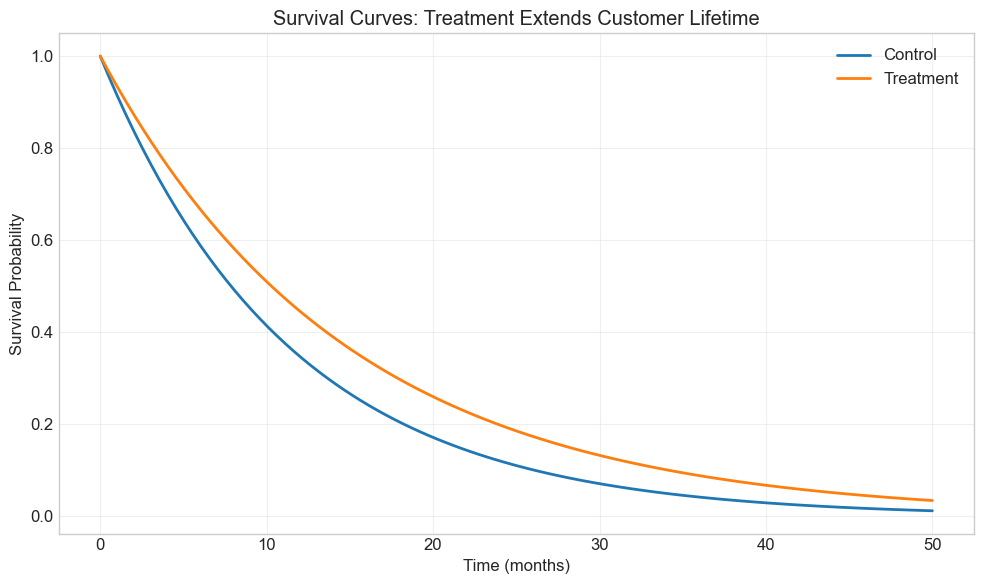

In [6]:
# Example: Time to customer churn (exponential)
np.random.seed(42)

# Control: mean survival time = 12 months
control_survival = np.random.exponential(12, 200)

# Treatment: mean survival time = 15 months (25% improvement)
treatment_survival = np.random.exponential(15, 200)

# Simple comparison of means
mean_control = np.mean(control_survival)
mean_treatment = np.mean(treatment_survival)
effect = mean_treatment - mean_control

# t-test (valid for exponential with large samples)
t_stat, p_value = stats.ttest_ind(treatment_survival, control_survival)

print("A/B Test: Time-to-Event (Customer Churn)")
print("="*50)
print(f"Control mean survival: {mean_control:.1f} months")
print(f"Treatment mean survival: {mean_treatment:.1f} months")
print(f"Effect: {effect:.1f} months ({(effect/mean_control)*100:.1f}% improvement)")
print(f"p-value: {p_value:.4f}")

# Visualize survival curves
fig, ax = plt.subplots(figsize=(10, 6))

time_points = np.linspace(0, 50, 100)
survival_control = np.exp(-time_points / mean_control)
survival_treatment = np.exp(-time_points / mean_treatment)

ax.plot(time_points, survival_control, label='Control', linewidth=2)
ax.plot(time_points, survival_treatment, label='Treatment', linewidth=2)
ax.set_xlabel('Time (months)')
ax.set_ylabel('Survival Probability')
ax.set_title('Survival Curves: Treatment Extends Customer Lifetime')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Part 3: Sample Size and Power Analysis

Before running an A/B test, we need to determine:
- **How many samples** do we need?
- **What effect size** can we detect?
- **What is our statistical power**?

In [7]:
def sample_size_continuous(baseline_mean, mde, baseline_std, alpha=0.05, power=0.80):
    """
    Calculate required sample size for continuous outcome.
    
    Parameters
    ----------
    baseline_mean : float
        Mean of control group
    mde : float
        Minimum detectable effect (absolute)
    baseline_std : float
        Standard deviation
    alpha : float
        Significance level (Type I error rate)
    power : float
        Statistical power (1 - Type II error rate)
    
    Returns
    -------
    int : Required sample size per group
    """
    # Effect size (Cohen's d)
    effect_size = mde / baseline_std
    
    # Z-scores
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)
    
    # Sample size formula
    n = 2 * ((z_alpha + z_beta) / effect_size)**2
    
    return int(np.ceil(n))

# Example: Revenue per user
n_required = sample_size_continuous(
    baseline_mean=100,
    mde=5,  # Want to detect $5 difference
    baseline_std=30,
    alpha=0.05,
    power=0.80
)

print("Sample Size Calculation")
print("="*50)
print(f"Baseline mean: $100")
print(f"Minimum detectable effect: $5 (5% lift)")
print(f"Standard deviation: $30")
print(f"Significance level: 0.05")
print(f"Power: 0.80")
print(f"\nRequired sample size per group: {n_required:,}")
print(f"Total sample size: {2*n_required:,}")

Sample Size Calculation
Baseline mean: $100
Minimum detectable effect: $5 (5% lift)
Standard deviation: $30
Significance level: 0.05
Power: 0.80

Required sample size per group: 566
Total sample size: 1,132


In [8]:
def sample_size_binary(p_control, mde_relative, alpha=0.05, power=0.80):
    """
    Calculate required sample size for binary outcome.
    
    Parameters
    ----------
    p_control : float
        Baseline conversion rate
    mde_relative : float
        Minimum detectable effect (relative, e.g., 0.10 for 10% lift)
    alpha : float
        Significance level
    power : float
        Statistical power
    """
    p_treatment = p_control * (1 + mde_relative)
    
    # Z-scores
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)
    
    # Pooled proportion
    p_pooled = (p_control + p_treatment) / 2
    
    # Sample size formula
    numerator = (z_alpha * np.sqrt(2 * p_pooled * (1 - p_pooled)) + 
                 z_beta * np.sqrt(p_control * (1 - p_control) + p_treatment * (1 - p_treatment)))**2
    denominator = (p_treatment - p_control)**2
    
    n = numerator / denominator
    
    return int(np.ceil(n))

# Example: Conversion rate
n_required = sample_size_binary(
    p_control=0.05,  # 5% baseline
    mde_relative=0.10,  # Want to detect 10% relative lift (5% → 5.5%)
    alpha=0.05,
    power=0.80
)

print("Sample Size Calculation (Binary)")
print("="*50)
print(f"Baseline conversion rate: 5.0%")
print(f"Minimum detectable effect: 10% relative lift (5.0% → 5.5%)")
print(f"Significance level: 0.05")
print(f"Power: 0.80")
print(f"\nRequired sample size per group: {n_required:,}")
print(f"Total sample size: {2*n_required:,}")

Sample Size Calculation (Binary)
Baseline conversion rate: 5.0%
Minimum detectable effect: 10% relative lift (5.0% → 5.5%)
Significance level: 0.05
Power: 0.80

Required sample size per group: 31,234
Total sample size: 62,468


### Power Curves

Visualize the relationship between sample size, effect size, and power.

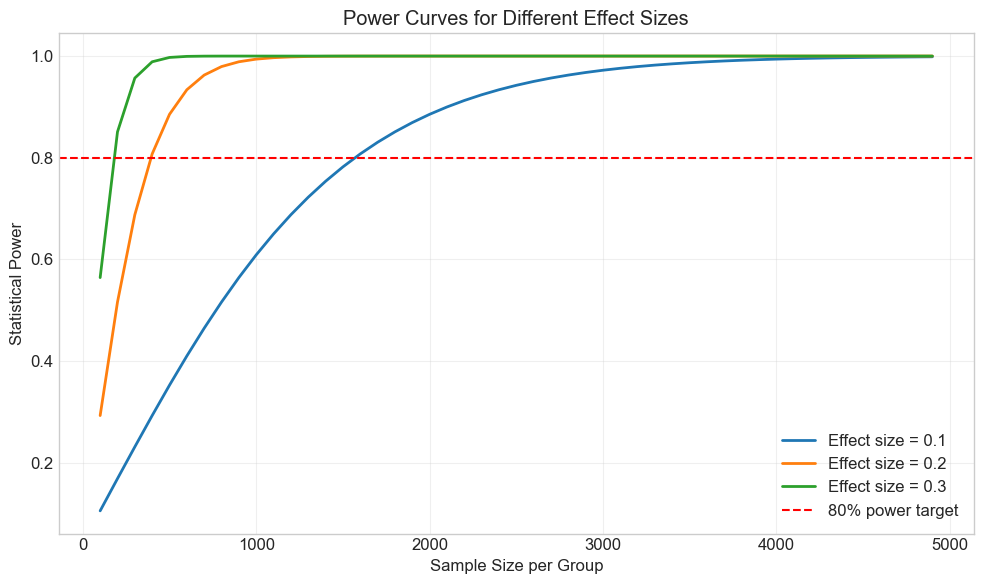

Key insight: Smaller effects require larger samples to detect reliably.


In [9]:
# Power as a function of sample size
sample_sizes = np.arange(100, 5000, 100)
effect_sizes = [0.1, 0.2, 0.3]  # Small, medium, large

fig, ax = plt.subplots(figsize=(10, 6))

for es in effect_sizes:
    powers = []
    for n in sample_sizes:
        # Compute power
        z_alpha = stats.norm.ppf(0.975)
        ncp = es * np.sqrt(n / 2)  # Non-centrality parameter
        power = 1 - stats.norm.cdf(z_alpha - ncp)
        powers.append(power)
    
    ax.plot(sample_sizes, powers, label=f'Effect size = {es}', linewidth=2)

ax.axhline(0.80, color='red', linestyle='--', label='80% power target')
ax.set_xlabel('Sample Size per Group')
ax.set_ylabel('Statistical Power')
ax.set_title('Power Curves for Different Effect Sizes')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key insight: Smaller effects require larger samples to detect reliably.")

---

## Part 4: Common Pitfalls

### 4.1 Peeking (Sequential Testing)

Checking results multiple times inflates Type I error rate.

In [10]:
def simulate_peeking_problem(n_peeks=10, n_final=1000, n_simulations=1000):
    """
    Demonstrate how peeking inflates false positive rate.
    """
    false_positives_no_peek = 0
    false_positives_peek = 0
    
    for _ in range(n_simulations):
        # Generate data with NO true effect
        control = np.random.normal(0, 1, n_final)
        treatment = np.random.normal(0, 1, n_final)  # Same distribution!
        
        # No peeking: test only at the end
        _, p_final = stats.ttest_ind(treatment, control)
        if p_final < 0.05:
            false_positives_no_peek += 1
        
        # Peeking: test at multiple points
        peek_points = np.linspace(100, n_final, n_peeks, dtype=int)
        stopped_early = False
        for n in peek_points:
            _, p = stats.ttest_ind(treatment[:n], control[:n])
            if p < 0.05:
                false_positives_peek += 1
                stopped_early = True
                break
    
    fpr_no_peek = false_positives_no_peek / n_simulations
    fpr_peek = false_positives_peek / n_simulations
    
    return fpr_no_peek, fpr_peek

fpr_no_peek, fpr_peek = simulate_peeking_problem()

print("The Peeking Problem")
print("="*50)
print(f"False positive rate (no peeking): {fpr_no_peek:.3f} (should be ~0.05)")
print(f"False positive rate (peeking 10x): {fpr_peek:.3f}")
print(f"\n⚠️  Peeking inflates false positives by {fpr_peek/fpr_no_peek:.1f}x!")
print("\nSolution: Use sequential testing methods (e.g., alpha spending functions)")

The Peeking Problem
False positive rate (no peeking): 0.041 (should be ~0.05)
False positive rate (peeking 10x): 0.166

⚠️  Peeking inflates false positives by 4.0x!

Solution: Use sequential testing methods (e.g., alpha spending functions)


### 4.2 Multiple Testing

Testing many metrics simultaneously increases false discovery rate.

In [11]:
# Simulate testing 20 metrics with no true effects
np.random.seed(42)
n_metrics = 20
n_per_group = 1000

p_values = []
for i in range(n_metrics):
    control = np.random.normal(0, 1, n_per_group)
    treatment = np.random.normal(0, 1, n_per_group)
    _, p = stats.ttest_ind(treatment, control)
    p_values.append(p)

# Uncorrected
n_significant_uncorrected = sum(p < 0.05 for p in p_values)

# Bonferroni correction
alpha_bonferroni = 0.05 / n_metrics
n_significant_bonferroni = sum(p < alpha_bonferroni for p in p_values)

print("Multiple Testing Problem")
print("="*50)
print(f"Number of metrics tested: {n_metrics}")
print(f"True effects: 0 (all null)")
print(f"\nSignificant at α=0.05 (uncorrected): {n_significant_uncorrected}")
print(f"Expected false positives: {n_metrics * 0.05:.1f}")
print(f"\nSignificant with Bonferroni correction: {n_significant_bonferroni}")
print(f"\n⚠️  Without correction, we'd falsely declare {n_significant_uncorrected} 'winners'!")

Multiple Testing Problem
Number of metrics tested: 20
True effects: 0 (all null)

Significant at α=0.05 (uncorrected): 0
Expected false positives: 1.0

Significant with Bonferroni correction: 0

⚠️  Without correction, we'd falsely declare 0 'winners'!


---

## Part 5: Bayesian A/B Testing

An alternative to frequentist testing using probability distributions.

Bayesian A/B Test
Probability treatment is better: 92.5%
Expected relative lift: 31.8%
95% Credible interval: [-9.1%, 85.7%]


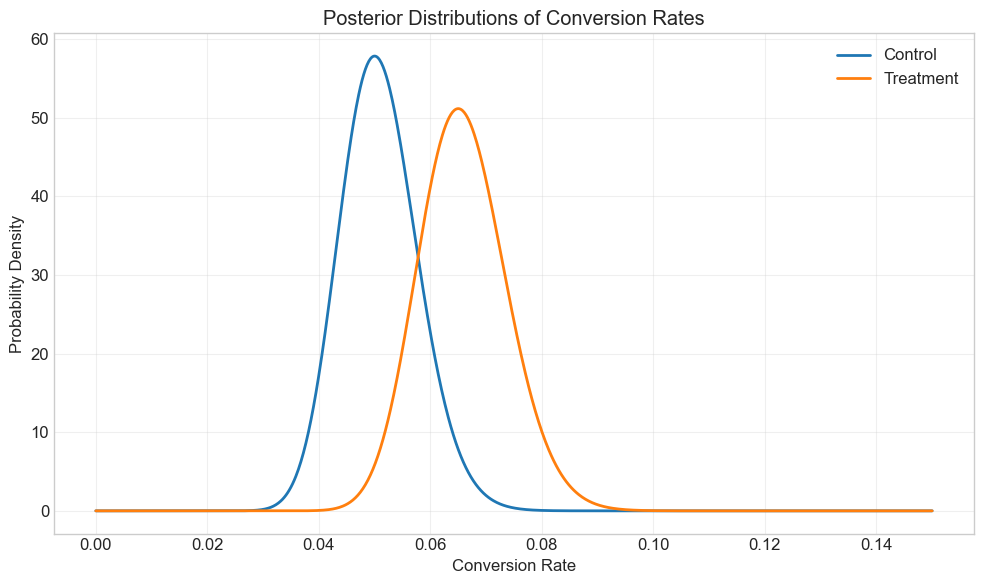

In [12]:
def bayesian_ab_test_binary(n_control, successes_control, n_treatment, successes_treatment,
                              prior_alpha=1, prior_beta=1):
    """
    Bayesian A/B test for binary outcomes using Beta-Binomial model.
    
    Prior: Beta(alpha, beta)
    Posterior: Beta(alpha + successes, beta + failures)
    """
    # Posterior distributions
    posterior_control = stats.beta(
        prior_alpha + successes_control,
        prior_beta + (n_control - successes_control)
    )
    
    posterior_treatment = stats.beta(
        prior_alpha + successes_treatment,
        prior_beta + (n_treatment - successes_treatment)
    )
    
    # Sample from posteriors
    n_samples = 100000
    samples_control = posterior_control.rvs(n_samples)
    samples_treatment = posterior_treatment.rvs(n_samples)
    
    # Probability that treatment > control
    prob_treatment_better = np.mean(samples_treatment > samples_control)
    
    # Expected lift
    lift_samples = (samples_treatment - samples_control) / samples_control
    expected_lift = np.mean(lift_samples)
    lift_ci = np.percentile(lift_samples, [2.5, 97.5])
    
    return {
        'prob_treatment_better': prob_treatment_better,
        'expected_lift': expected_lift,
        'lift_ci_lower': lift_ci[0],
        'lift_ci_upper': lift_ci[1],
        'posterior_control': posterior_control,
        'posterior_treatment': posterior_treatment,
    }

# Example
result = bayesian_ab_test_binary(
    n_control=1000,
    successes_control=50,
    n_treatment=1000,
    successes_treatment=65
)

print("Bayesian A/B Test")
print("="*50)
print(f"Probability treatment is better: {result['prob_treatment_better']:.1%}")
print(f"Expected relative lift: {result['expected_lift']*100:.1f}%")
print(f"95% Credible interval: [{result['lift_ci_lower']*100:.1f}%, {result['lift_ci_upper']*100:.1f}%]")

# Visualize posteriors
fig, ax = plt.subplots(figsize=(10, 6))

x = np.linspace(0, 0.15, 1000)
ax.plot(x, result['posterior_control'].pdf(x), label='Control', linewidth=2)
ax.plot(x, result['posterior_treatment'].pdf(x), label='Treatment', linewidth=2)
ax.set_xlabel('Conversion Rate')
ax.set_ylabel('Probability Density')
ax.set_title('Posterior Distributions of Conversion Rates')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Summary

### Key Takeaways

1. **Randomization is magic**: It eliminates confounding without needing to measure or adjust for confounders
2. **Choose the right test**: Match your statistical test to your outcome distribution
3. **Plan sample size**: Don't run underpowered experiments
4. **Avoid peeking**: Sequential testing requires special methods
5. **Correct for multiple testing**: Testing many metrics inflates false positives

### When to Use What

| Outcome Type | Distribution | Test |
|--------------|--------------|------|
| Continuous (revenue, expression) | Normal | t-test |
| Binary (conversion, click) | Binomial | Proportion test |
| Count (events, mutations) | Poisson | Poisson test |
| Time-to-event (churn, survival) | Exponential/Weibull | Log-rank test |

### Next Steps

- `../causal_inference/01_treatment_effects.ipynb`: What to do when randomization isn't possible
- `../causal_inference/02_causal_graphs.ipynb`: Understanding confounding with DAGs